In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tcvae import tsms
from tcvae import dataset, model, localconfig
from IPython.display import Audio

plt.style.use("dark_background")

2021-06-27 07:39:35.984 | INFO     | tcvae.train:<module>:18 - 1


## Setup Config, Load Test Set and Model

In [2]:
conf = localconfig.LocalConfig()
conf.latent_dim = 64
conf.decoder_type = "conv"

_, _, test = dataset.get_dataset(conf)
test_iterable = iter(test)

vae = model.create_vae(conf)
vae.load_weights("checkpoints/0_VAE_0.4004.h5")

In [10]:
def reconstruct_audio(freq, mag):
    phase = tsms.core.generate_phase(
        freq, conf.sample_rate,
        conf.frame_size
    )
    return tsms.core.harmonic_synthesis(
        h_freq=freq, h_mag=mag, h_phase=phase,
        sample_rate=conf.sample_rate,
        frame_step=conf.frame_size
    )


def get_prediction(batch, **kwargs):
    h = batch["h"]
    note_number = batch["note_number"]
    velocity= batch["velocity"]
    instrument_id = batch["instrument_id"]

    if kwargs.get("instrument_id") is not None:
        desired_id = kwargs.get("instrument_id")
        instrument_id = np.zeros((1, 74))
        instrument_id[0, desired_id] = 1.

    if kwargs.get("note_number") is not None:
        desired_pitch = kwargs.get("note_number")
        note_number = np.zeros((1, 49))
        note_number[0, desired_pitch] = 1.

    if kwargs.get("velocity") is not None:
        desired_velocity = kwargs.get("velocity")
        velocity = np.zeros((1, 5))
        velocity[0, desired_velocity] = 1.

    pred, z_mean, z_log_variance = vae.predict([h, note_number, instrument_id, velocity])
    pitch = 40 + tf.argmax(note_number[0])
    f0_from_note = tsms.core.midi_to_hz(
        tf.cast(pitch, dtype=tf.float32)
    )

    harmonics = tsms.core.get_number_harmonics(
        f0_from_note, conf.sample_rate
    )

    h_freq_pred = pred[:, :1001, :harmonics, 0]
    h_mag_pred = pred[:, :1001, :harmonics, 1]

    h_freq_gt = h[:, :1001, :harmonics, 0]
    h_mag_gt = h[:, :1001, :harmonics, 1]

    harmonic_indices = tf.range(1, harmonics + 1, dtype=tf.float32)

    h_freq_centered = h_freq_pred * f0_from_note
    h_freq_pred = h_freq_centered + f0_from_note * harmonic_indices

    h_freq_centered_gt = h_freq_gt * f0_from_note
    h_freq_gt = h_freq_centered_gt + f0_from_note * harmonic_indices

    h_mag_gt = np.clip(h_mag_gt, 0, 1)
    h_mag_pred = np.clip(h_mag_pred, 0, 1)

    low_amp = h_mag_pred < 0.001
    h_mag_pred[low_amp] = 0.

    # db_limit = 120
    # h_mag_pred = h_mag_pred * db_limit - db_limit
    # h_mag_gt = h_mag_gt * db_limit - db_limit
    #
    # h_mag_pred = tsms.core.db_to_lin(h_mag_pred)
    # h_mag_gt = tsms.core.db_to_lin(h_mag_gt)
    #
    # harmonic_indices = tf.range(1, harmonics + 1, dtype=tf.float32)
    # harmonic_indices = harmonic_indices.numpy()
    #
    # f_var = f0_from_note * harmonic_indices * (2.0 ** (1.0 / 12.0) - 1.0)
    # h_freq_centered = h_freq_pred * f_var
    # h_freq_pred = h_freq_centered + f0_from_note * harmonic_indices
    #
    # h_freq_centered_gt = h_freq_gt * f_var
    # h_freq_gt = h_freq_centered_gt + f0_from_note * harmonic_indices


    return (h_freq_pred, h_mag_pred), (h_freq_gt, h_mag_gt)

## Get Predictions

In [11]:
batch = next(test_iterable)

In [12]:
(h_freq_pred, h_mag_pred), (h_freq_gt, h_mag_gt) = get_prediction(
    batch, # instrument_id=30, velocity=4, note_number=11
)

In [13]:
audio_pred = reconstruct_audio(
    h_freq_pred, h_mag_pred
)

Audio(audio_pred, rate=conf.sample_rate)

In [14]:
audio_gt = reconstruct_audio(
    h_freq_gt, h_mag_gt
)

Audio(audio_gt, rate=conf.sample_rate)

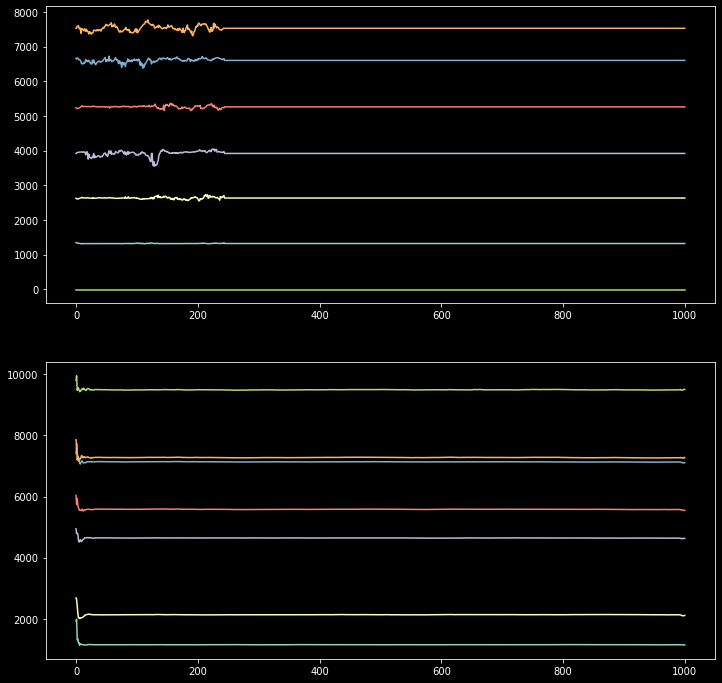

In [15]:
plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
plt.plot(h_freq_gt[0])

plt.subplot(2, 1, 2)
plt.plot(h_freq_pred[0])

plt.savefig("freq.png")

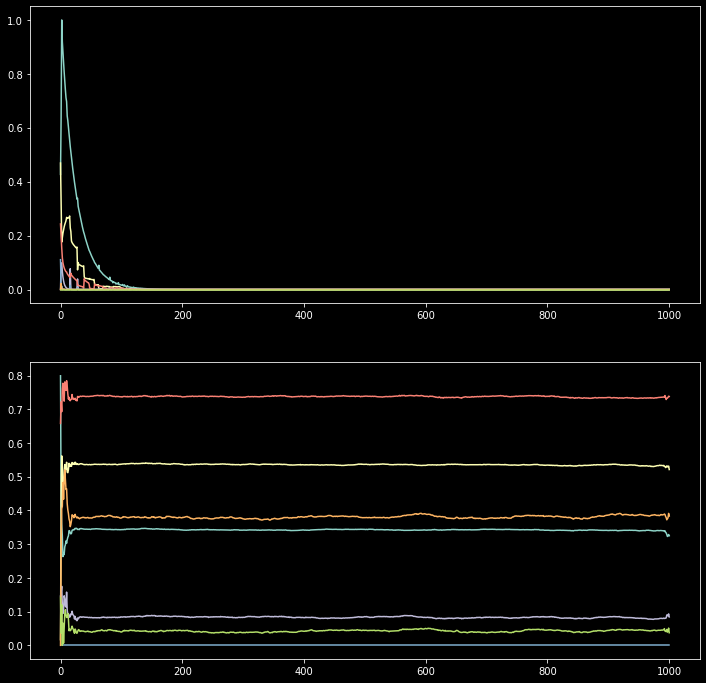

In [16]:
plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
plt.plot(h_mag_gt[0])

plt.subplot(2, 1, 2)
plt.plot(h_mag_pred[0])

plt.savefig("mag.png")